<a href="https://colab.research.google.com/github/ikeratzakis/taxi-analysis/blob/main/trip_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports and loading data from google drive

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/MyDrive/Datasets/trip_data/'
df_train = pd.read_csv(path + 'train.csv')
df_target = pd.read_csv(path + 'target.csv')
df_test = pd.read_csv(path + 'test.csv')

Mounted at /content/drive


Let's find out the structure of the train dataset

In [2]:
df_train.head()


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2575240,2,2016-04-09 08:41:59,2016-04-09 08:48:11,1,-73.976501,40.788368,-73.957657,40.782452,N,372
1,id3828278,2,2016-04-07 11:12:45,2016-04-07 11:24:24,1,-73.992310,40.769211,-73.990662,40.758137,N,699
2,id1483137,2,2016-04-15 19:53:35,2016-04-15 20:04:49,1,-73.994713,40.746391,-73.969742,40.758484,N,674
3,id0416660,2,2016-04-21 00:47:17,2016-04-21 00:53:41,1,-73.988358,40.718460,-73.951538,40.713840,N,384
4,id2363476,1,2016-01-26 18:34:23,2016-01-26 19:09:14,1,-73.992332,40.743576,-73.979309,40.678200,N,2091


Now let's see some statistics

In [3]:
df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.166915e+06,1.166915e+06,1.166915e+06,1.166915e+06,1.166915e+06,1.166915e+06,1.166915e+06
mean,1.534915e+00,1.665292e+00,-7.397346e+01,4.075089e+01,-7.397340e+01,4.075182e+01,9.584392e+02
std,4.987797e-01,1.314746e+00,6.231408e-02,3.173031e-02,6.157028e-02,3.645646e-02,5.334345e+03
min,1.000000e+00,0.000000e+00,-1.219332e+02,3.435970e+01,-1.219332e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399186e+01,4.073731e+01,-7.399133e+01,4.073591e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398175e+01,4.075407e+01,-7.397977e+01,4.075453e+01,6.630000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076834e+01,-7.396303e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,4.437194e+01,-6.133553e+01,4.392103e+01,3.526282e+06


Remove outliers. We will define them as being further than 2*standard_deviation from their mean. (trip_duration column)

In [4]:
mean_duration = np.mean(df_train['trip_duration'])
std_duration = np.std(df_train['trip_duration'])
print('Mean trip duration is ', mean_duration)
print('Trip duration standard deviation is ', std_duration)
print('Train set size before removing duration outliers', len(df_train))
df_train = df_train[np.abs(df_train.trip_duration-mean_duration) <= (2*std_duration)]
print('Train set size after removing duration outliers', len(df_train))


Mean trip duration is  958.4392359340654
Trip duration standard deviation is  5334.34225041338
Train set size before removing duration outliers 1166915
Train set size after removing duration outliers 1165250


Remove data points that are outside New York's limits (-74.03, -73.75) (40.63, 40.85)

In [5]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
df_train = df_train[(df_train.pickup_longitude.between(city_long_border[0], city_long_border[1])) & (df_train.dropoff_longitude.between(city_long_border[0], city_long_border[1])) &
                    (df_train.pickup_latitude.between(city_lat_border[0], city_lat_border[1])) & (df_train.dropoff_latitude.between(city_lat_border[0], city_lat_border[1]))]
print('Train set size after keeping only points inside NY', len(df_train))

Train set size after keeping only points inside NY 1149734


Split datetime columns to 6 different ones: day_period, day_name, month, hour, year, season

In [6]:
df_train['pickup_datetime'] = pd.to_datetime(df_train.pickup_datetime)
df_train['dropoff_datetime'] = pd.to_datetime(df_train.dropoff_datetime)
df_test['pickup_datetime'] = pd.to_datetime(df_test.pickup_datetime)
df_test['dropoff_datetime'] = pd.to_datetime(df_test.pickup_datetime)

season_dict = {1:'winter', 2:'winter', 3:'spring', 4:'spring', 5:'spring', 6:'summer', 7:'summer', 8:'summer', 9:'fall', 10:'fall', 11:'fall'}

def hour_to_period(hour):
  if hour in [22, 23, 0, 1, 2, 3, 4, 5]:
    period = 'late night'
  elif hour in [6, 7, 8, 9, 10, 11]:
    period = 'morning'
  elif hour in [12, 13, 14, 15]:
    period = 'afternoon'
  elif hour in [16, 17, 18, 19, 20, 21]:
    period = 'evening'
  return period

for df in df_train, df_test:
  df['pickup_day_name'] = df['pickup_datetime'].dt.day_name()
  df['pickup_month'] = df['pickup_datetime'].dt.month
  df['pickup_hour'] = df['pickup_datetime'].dt.hour
  df['pickup_year'] = df['pickup_datetime'].dt.year
  df['pickup_season'] = df['pickup_month'].map(season_dict)
  df['pickup_period'] = df['pickup_hour'].map(hour_to_period)

  df['dropoff_day_name'] = df['dropoff_datetime'].dt.day_name()
  df['dropoff_month'] = df['dropoff_datetime'].dt.month
  df['dropoff_hour'] = df['dropoff_datetime'].dt.hour
  df['dropoff_year'] = df['dropoff_datetime'].dt.year
  df['dropoff_season'] = df['dropoff_month'].map(season_dict)
  df['dropoff_period'] = df['dropoff_hour'].map(hour_to_period)

df_train.head


<bound method NDFrame.head of                 id  vendor_id     pickup_datetime    dropoff_datetime  \
0        id2575240          2 2016-04-09 08:41:59 2016-04-09 08:48:11   
1        id3828278          2 2016-04-07 11:12:45 2016-04-07 11:24:24   
2        id1483137          2 2016-04-15 19:53:35 2016-04-15 20:04:49   
3        id0416660          2 2016-04-21 00:47:17 2016-04-21 00:53:41   
4        id2363476          1 2016-01-26 18:34:23 2016-01-26 19:09:14   
...            ...        ...                 ...                 ...   
1166910  id1738756          2 2016-03-27 10:45:13 2016-03-27 10:53:33   
1166911  id3231673          1 2016-03-24 23:49:58 2016-03-25 00:06:52   
1166912  id0863928          1 2016-06-24 21:55:33 2016-06-24 22:01:47   
1166913  id1088182          1 2016-01-15 11:56:08 2016-01-15 12:05:33   
1166914  id2591162          2 2016-01-11 08:09:13 2016-01-11 08:15:50   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1      

Create histograms from pickup/dropoff days, and trips per day_period/month

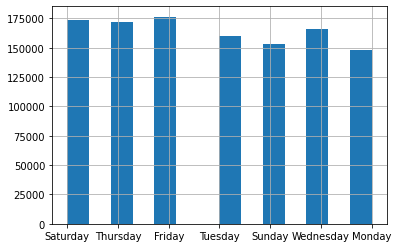

In [7]:
pickup_day_hist = df_train['pickup_day_name'].hist(bins = 14)

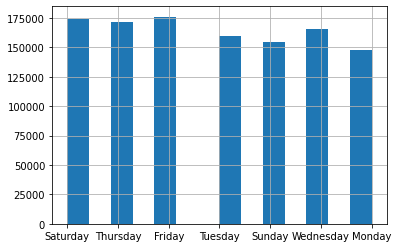

In [8]:
dropoff_day_hist = df_train['dropoff_day_name'].hist(bins = 14)

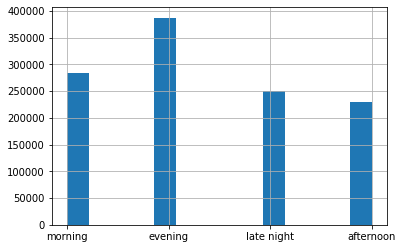

In [9]:
pickup_period_hist = df_train['pickup_period'].hist(bins = 14)

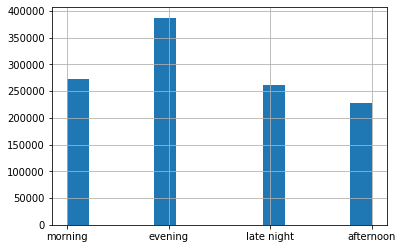

In [10]:
dropoff_period_hist = df_train['dropoff_period'].hist(bins = 14)

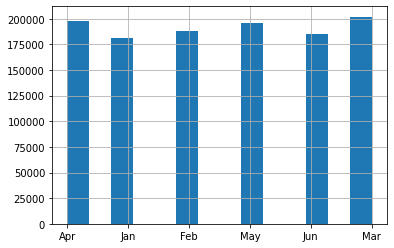

In [11]:
month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
pickup_month_hist = df_train['pickup_month'].map(month_dict).hist(bins = 14)


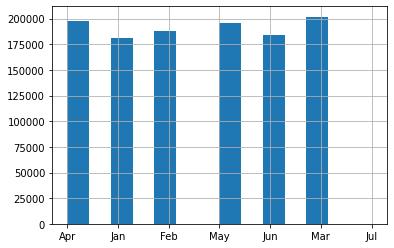

In [12]:
dropoff_month_hist = df_train['dropoff_month'].map(month_dict).hist(bins = 14)

Calculate average trip duration per pickup hour/day_period/day of week

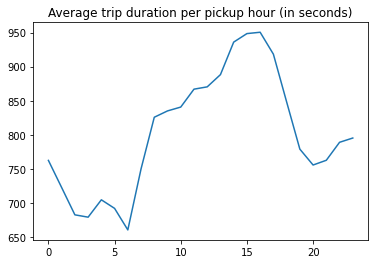

In [13]:
group_hour_df_train = df_train[['pickup_hour', 'trip_duration']]
group_hour_df_train = group_hour_df_train.groupby('pickup_hour')
mean_group_hour_df_train = group_hour_df_train.mean().reset_index()

plt.plot(mean_group_hour_df_train['pickup_hour'], mean_group_hour_df_train['trip_duration']), plt.title('Average trip duration per pickup hour (in seconds)')
plt.show()


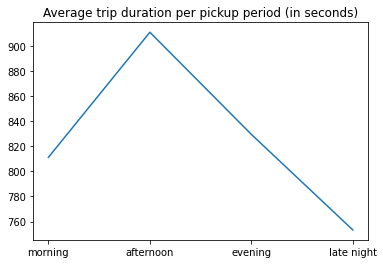

In [14]:
group_period_df_train = df_train[['pickup_period', 'trip_duration']]
group_period_df_train = group_period_df_train.groupby('pickup_period')
mean_group_period_df_train = group_period_df_train.mean().reset_index().reindex([3, 0, 1, 2])

plt.plot(mean_group_period_df_train['pickup_period'], mean_group_period_df_train['trip_duration']), plt.title('Average trip duration per pickup period (in seconds)')
plt.show()

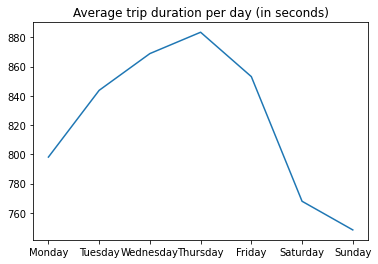

In [15]:
group_day_df_train = df_train[['pickup_day_name', 'trip_duration']]
group_day_df_train = group_day_df_train.groupby('pickup_day_name')
mean_group_day_df_train = group_day_df_train.mean().reset_index().reindex([1, 5, 6, 4, 0, 2, 3])

plt.plot(mean_group_day_df_train['pickup_day_name'], mean_group_day_df_train['trip_duration']), plt.title('Average trip duration per day (in seconds)')
plt.show()

Plot trip duration histogram, and then transform them to log and plot again

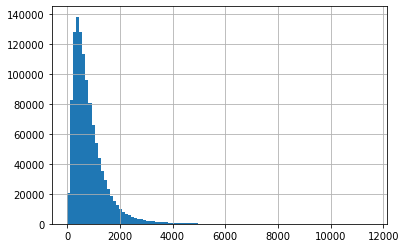

In [16]:
duration_hist = df_train['trip_duration'].hist(bins = 100)

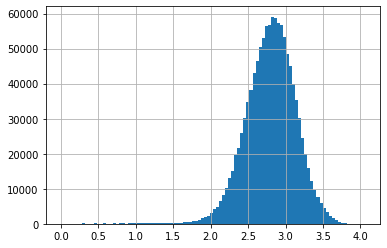

In [17]:
df_train['log_trip_duration'] = np.log10(df_train['trip_duration'])
log_duration_hist = df_train['log_trip_duration'].hist(bins = 100)

Group by vendor id and plot average trip duration

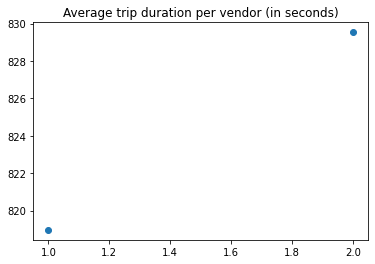

In [19]:
group_vendor_df_train = df_train[['vendor_id', 'trip_duration']]
group_vendor_df_train = group_vendor_df_train.groupby('vendor_id')
mean_group_vendor_df_train = group_vendor_df_train.mean().reset_index()

plt.scatter(mean_group_vendor_df_train['vendor_id'], mean_group_vendor_df_train['trip_duration']), plt.title('Average trip duration per vendor (in seconds)')
plt.show()

Group by passenger count and plot again

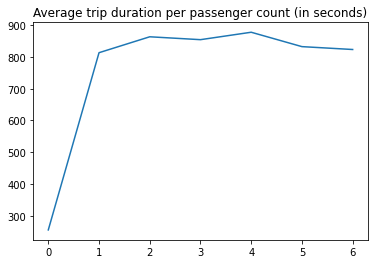

In [21]:
group_passenger_df_train = df_train[['passenger_count', 'trip_duration']]
group_passenger_df_train = group_passenger_df_train.groupby('passenger_count')
mean_group_passenger_df_train = group_passenger_df_train.mean().reset_index()

plt.plot(mean_group_passenger_df_train['passenger_count'], mean_group_passenger_df_train['trip_duration']), plt.title('Average trip duration per passenger count (in seconds)')
plt.show()

Calculate Manhattan distance between points and plot duration/distance and distance/day

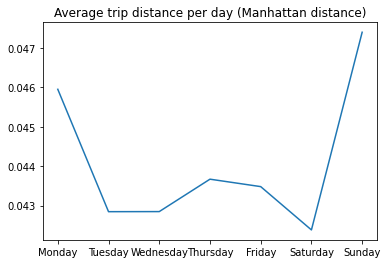

In [26]:
df_train['distance'] = abs(df_train['dropoff_latitude'] - df_train['pickup_latitude']) + abs(df_train['dropoff_longitude'] - df_train['pickup_longitude'])

group_day_df_train = df_train[['pickup_day_name', 'distance']]
group_day_df_train = group_day_df_train.groupby('pickup_day_name')
mean_group_day_df_train = group_day_df_train.mean().reset_index().reindex([1, 5, 6, 4, 0, 2, 3])

plt.plot(mean_group_day_df_train['pickup_day_name'], mean_group_day_df_train['distance']), plt.title('Average trip distance per day (Manhattan distance)')
plt.show()

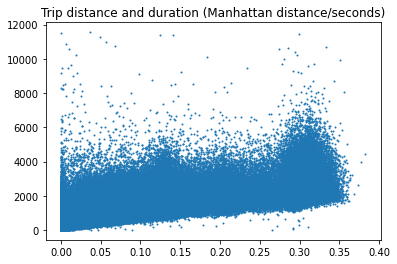

In [37]:
plt.scatter(df_train['distance'], df_train['trip_duration'], s=1), plt.title('Trip distance and duration (Manhattan distance/seconds)')
plt.show()

Calculate velocity, and group average velocity by hour/day/month

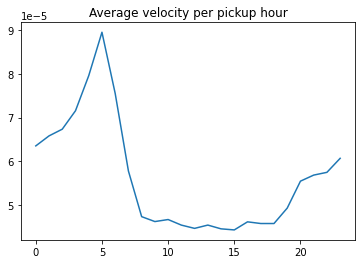

In [39]:
df_train['velocity'] = df_train['distance']/df_train['trip_duration']

group_hour_df_train = df_train[['pickup_hour', 'velocity']]
group_hour_df_train = group_hour_df_train.groupby('pickup_hour')
mean_group_hour_df_train = group_hour_df_train.mean().reset_index()

plt.plot(mean_group_hour_df_train['pickup_hour'], mean_group_hour_df_train['velocity']), plt.title('Average velocity per pickup hour')
plt.show()

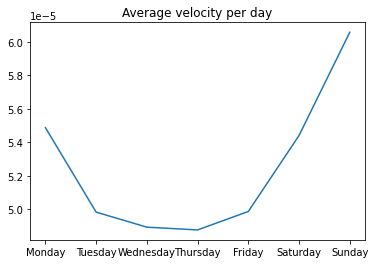

In [40]:
group_day_df_train = df_train[['pickup_day_name', 'velocity']]
group_day_df_train = group_day_df_train.groupby('pickup_day_name')
mean_group_day_df_train = group_day_df_train.mean().reset_index().reindex([1, 5, 6, 4, 0, 2, 3])

plt.plot(mean_group_day_df_train['pickup_day_name'], mean_group_day_df_train['velocity']), plt.title('Average velocity per day')
plt.show()

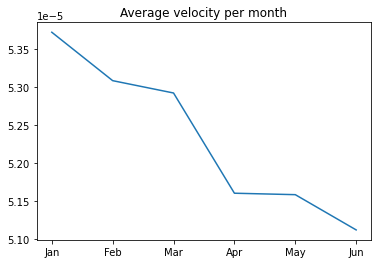

In [44]:
group_month_df_train = df_train[['pickup_month', 'velocity']]
group_month_df_train = group_month_df_train.groupby('pickup_month')
mean_group_month_df_train = group_month_df_train.mean().reset_index()

plt.plot(mean_group_month_df_train['pickup_month'].map(month_dict), mean_group_month_df_train['velocity']), plt.title('Average velocity per month')
plt.show()

Create scatter plots for latitude/longitude

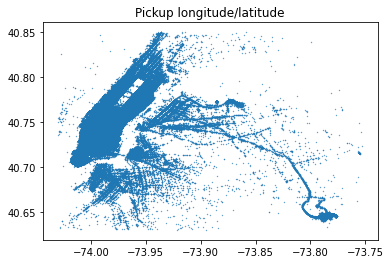

In [51]:
plt.scatter(df_train['pickup_longitude'], df_train['pickup_latitude'], s=0.1), plt.title('Pickup longitude/latitude')
plt.show()

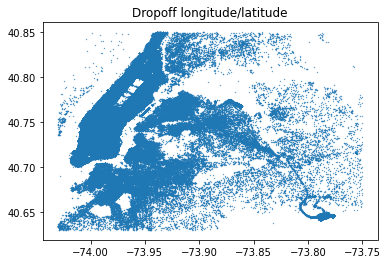

In [52]:
plt.scatter(df_train['dropoff_longitude'], df_train['dropoff_latitude'], s=0.1), plt.title('Dropoff longitude/latitude')
plt.show()